In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import xgi
import torch
from sklearn.decomposition import PCA
from kmeans_pytorch import kmeans
import seaborn as sns

In [2]:
users = pd.read_json('babynamesDB_users.json')
# User features are num_comments_stored, num_groups, num_posts_stored
users['num_groups'] = [len(i) for i in users['groups']]
users = users[['_id', 'num_comments_stored', 'num_posts_stored','num_groups']]
#convert users id to integer index
user_data = users
user_data['id'] = user_data['_id'].astype('category').cat.codes
user_data = user_data[['num_comments_stored', 'num_posts_stored', 'num_groups']]
# convert pandas dataframe to torch tensor
users_tensor = torch.tensor(user_data.values)
# create embeddings for users and pass in users_tensor as input
user_embeddings = torch.nn.Embedding(len(user_data), 3)
user_embeddings.weight.data.copy_(users_tensor)


tensor([[552.,   8.,   6.],
        [ 31.,   4.,   3.],
        [ 62.,   0.,   1.],
        ...,
        [  3.,   0.,   1.],
        [  4.,   3.,   2.],
        [  0.,   1.,   1.]])

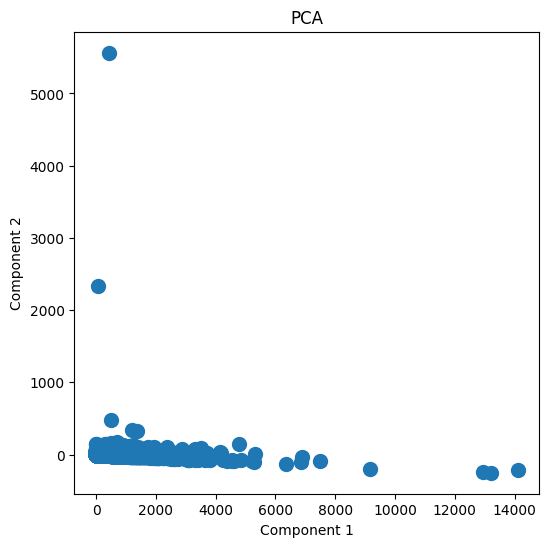

running k-means on cpu..


[running kmeans]: 48it [00:01, 38.96it/s, center_shift=0.000000, iteration=48, tol=0.000100]    


Cluster 0 has 86 users with cluster center 3748.48828125 comments, 43.430233001708984 posts, 11.116278648376465 groups
Cluster 1 has 2407 users with cluster center 645.5076904296875 comments, 24.115495681762695 posts, 6.7532196044921875 groups
Cluster 2 has 367428 users with cluster center 10.478047370910645 comments, 1.4760905504226685 posts, 1.510921835899353 groups


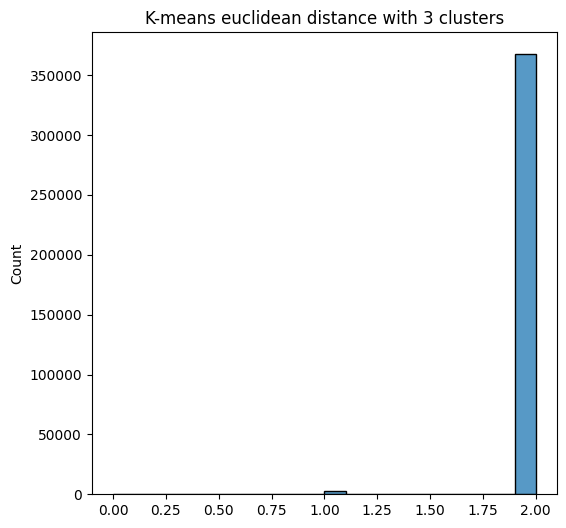

running k-means on cpu..


[running kmeans]: 18it [00:00, 18.33it/s, center_shift=0.000000, iteration=18, tol=0.000100]


Cluster 0 has 176282 users with cluster center 2.1719233989715576 comments, 0.23616138100624084 posts, 1.3036158084869385 groups
Cluster 1 has 115383 users with cluster center 45.403709411621094 comments, 3.3529982566833496 posts, 2.1361465454101562 groups
Cluster 2 has 78256 users with cluster center 1.3334184885025024 comments, 2.2442750930786133 posts, 1.2278547286987305 groups


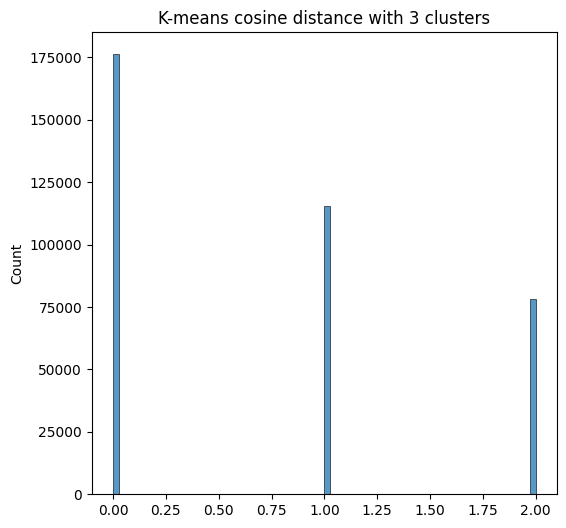

In [3]:
X = user_embeddings.weight.data.numpy()
pca = PCA(n_components=2)
components = pca.fit_transform(X)

plt.figure(figsize=(6, 6))
plt.scatter(components[:, 0], components[:, 1], s=100)
plt.title('PCA')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.show()

cluster_ids_x, cluster_centers = kmeans(X=users_tensor, num_clusters=3, distance='euclidean')
clusters = np.bincount(cluster_ids_x)
for i, cluster in enumerate(clusters):
    print(f"Cluster {i} has {cluster} users with cluster center {cluster_centers[i][0]} comments, {cluster_centers[i][1]} posts, {cluster_centers[i][2]} groups")

# histogram of 3 clusters
plt.figure(figsize=(6, 6))
sns.histplot(cluster_ids_x)
plt.title('K-means euclidean distance with 3 clusters')
plt.show()

cluster_ids_x, cluster_centers = kmeans(X=users_tensor, num_clusters=3, distance='cosine')
clusters = np.bincount(cluster_ids_x)
for i, cluster in enumerate(clusters):
    print(f"Cluster {i} has {cluster} users with cluster center {cluster_centers[i][0]} comments, {cluster_centers[i][1]} posts, {cluster_centers[i][2]} groups")


# histogram of 3 clusters
plt.figure(figsize=(6, 6))
sns.histplot(cluster_ids_x)
plt.title('K-means cosine distance with 3 clusters')
plt.show()

In [4]:
import torch.nn.functional as F

def euclidean_distance(x1, x2):
    """
    Compute the Euclidean distance between two vectors x1 and x2.
    """
    return torch.norm(x1.unsqueeze(0) - x2.unsqueeze(0)).item()

def cosine_similarity(x1, x2):
    """
    Compute cosine similarity between two vectors x1 and x2.
    """
    return F.cosine_similarity(x1.unsqueeze(0), x2.unsqueeze(0)).item()

def create_social_graph(embeddings, threshold, metric):
    """
    Create a social graph based on cosine similarity and a threshold.
    An edge is added between two nodes (users) if their cosine similarity is above the threshold.
    """
    num_users = embeddings.shape[0]
    social_graph = nx.Graph()
    
    for i in range(num_users):
        for j in range(i+1, num_users):  # Avoids duplicate checks and self-connections
            if metric == 'euclidean':
                similarity = euclidean_distance(embeddings[i], embeddings[j])
            elif metric == 'cosine':
                similarity = cosine_similarity(embeddings[i], embeddings[j])
            if similarity >= threshold:
                social_graph.add_edge(i, j)
                
    return social_graph




/usr/local/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/usr/local/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


Text(0, 0.5, 'log10(degree)')

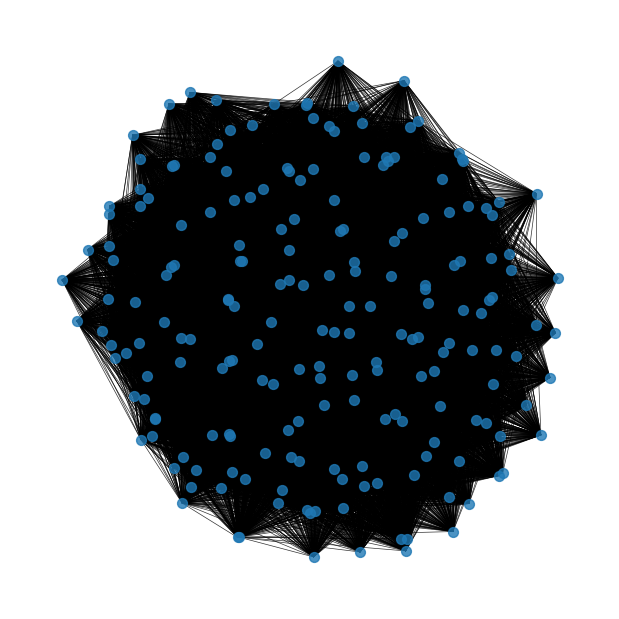

<Figure size 600x600 with 0 Axes>

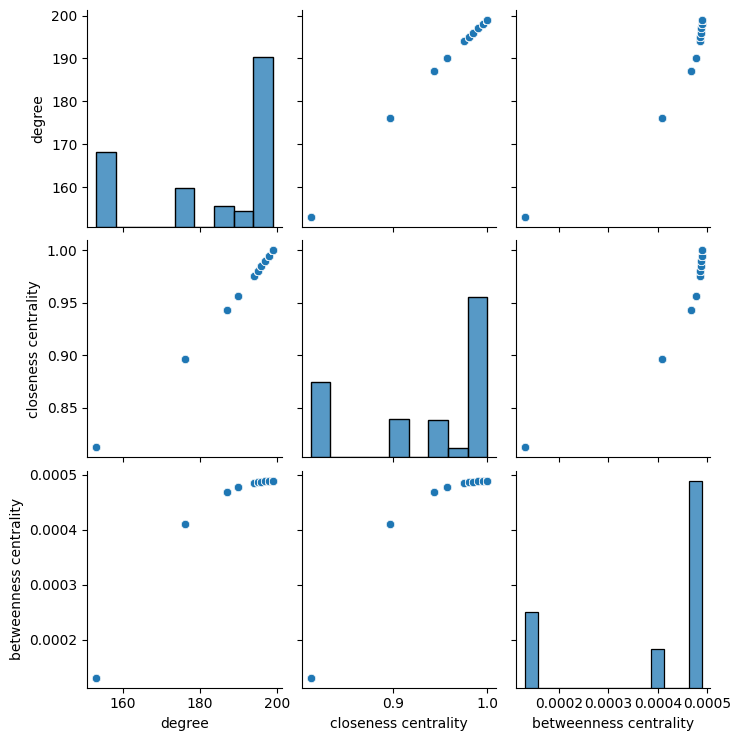

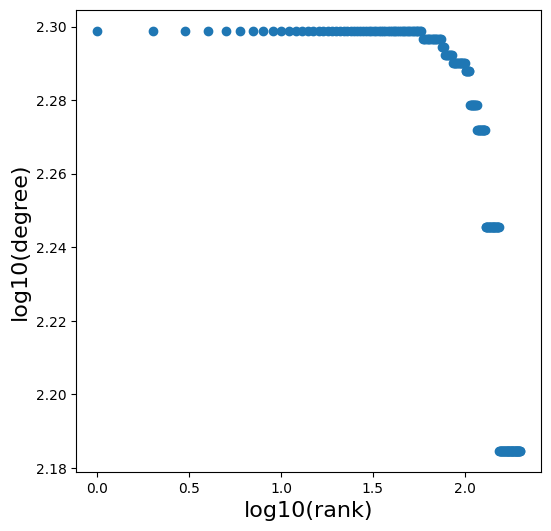

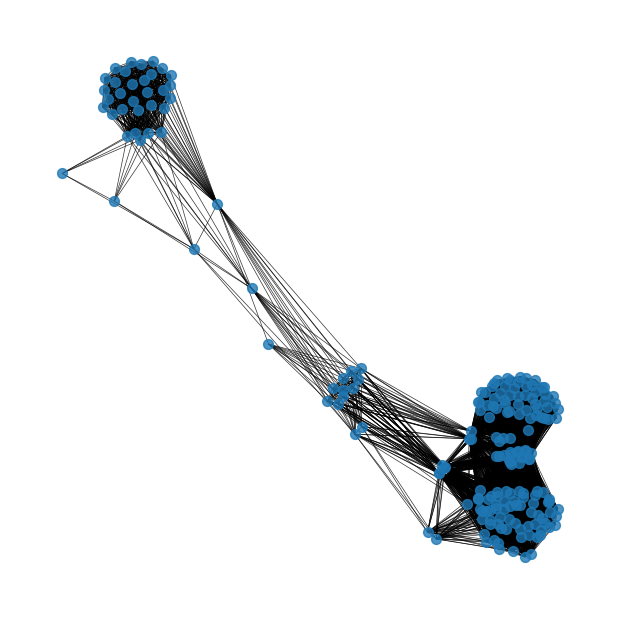

<Figure size 600x600 with 0 Axes>

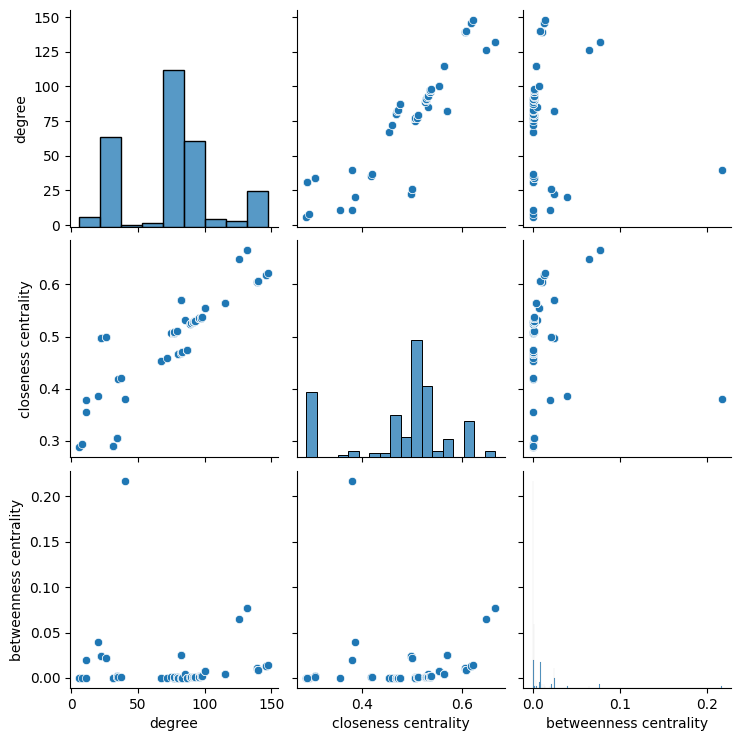

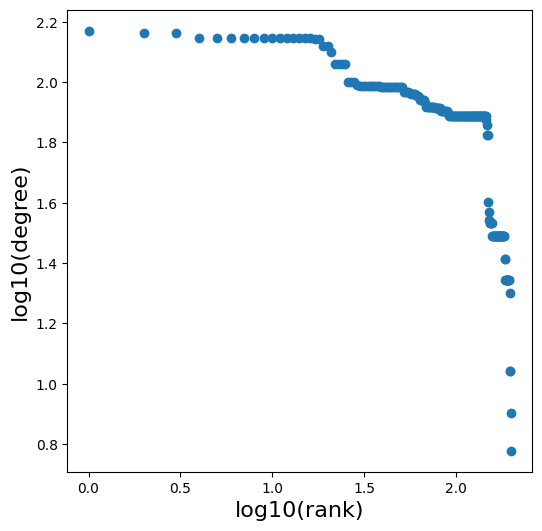

In [5]:
# subsample 1000 users from users_tensor
users_tensor_subsample = users_tensor[torch.randperm(len(users_tensor))[:200]]
users_tensor_subsample = users_tensor_subsample.float()

plt.figure(figsize=(6, 6))
# create social graph
social_graph = create_social_graph(users_tensor_subsample, threshold=0.9, metric='euclidean')
pos = nx.spring_layout(social_graph)
nx.draw(social_graph, pos=pos, node_size=50, width=0.5, alpha=0.8, with_labels=False)

plt.figure(figsize=(6, 6))
degrees = list(dict(social_graph.degree()).values())
closeness = list(nx.closeness_centrality(social_graph).values())
betweens = list(nx.betweenness_centrality(social_graph).values())
data = pd.DataFrame({'degree': degrees, 'closeness centrality': closeness, 'betweenness centrality': betweens})
#sort data by degree
data = data.sort_values(by=['degree'])
sns.pairplot(pd.DataFrame(data))

plt.figure(figsize=(6, 6))
plt.scatter(np.log10(range(1, social_graph.number_of_nodes() + 1)) ,np.log10(sorted(list(dict(social_graph.degree()).values()))[::-1]))
plt.xlabel("log10(rank)", fontsize=16)
plt.ylabel("log10(degree)", fontsize=16)

plt.figure(figsize=(6, 6))
# create social graph
social_graph = create_social_graph(users_tensor_subsample, threshold=0.9, metric='cosine')
pos = nx.spring_layout(social_graph)
nx.draw(social_graph, pos=pos, node_size=50, width=0.5, alpha=0.8, with_labels=False)

plt.figure(figsize=(6, 6))
degrees = list(dict(social_graph.degree()).values())
closeness = list(nx.closeness_centrality(social_graph).values())
betweens = list(nx.betweenness_centrality(social_graph).values())
data = pd.DataFrame({'degree': degrees, 'closeness centrality': closeness, 'betweenness centrality': betweens})
#sort data by degree
data = data.sort_values(by=['degree'])
sns.pairplot(pd.DataFrame(data))

plt.figure(figsize=(6, 6))
plt.scatter(np.log10(range(1, social_graph.number_of_nodes() + 1)) ,np.log10(sorted(list(dict(social_graph.degree()).values()))[::-1]))
plt.xlabel("log10(rank)", fontsize=16)
plt.ylabel("log10(degree)", fontsize=16)


In [6]:
users = pd.read_json('babynamesDB_users.json')
users = users[['_id', 'groups']]
users = users.explode('groups')

In [7]:
H = xgi.Hypergraph(users)
print(f"The hypergraph has {H.num_nodes} nodes and {H.num_edges} edges")

The hypergraph has 369921 nodes and 1793 edges


/var/folders/nc/f0r8ntk94231ntskwgzw2j0h0000gn/T/ipykernel_25840/2291249328.py:1: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(np.log10(range(H.num_nodes)) ,np.log10(sorted(list(H.degree().values()))[::-1]))


Text(0, 0.5, 'log10(degree)')

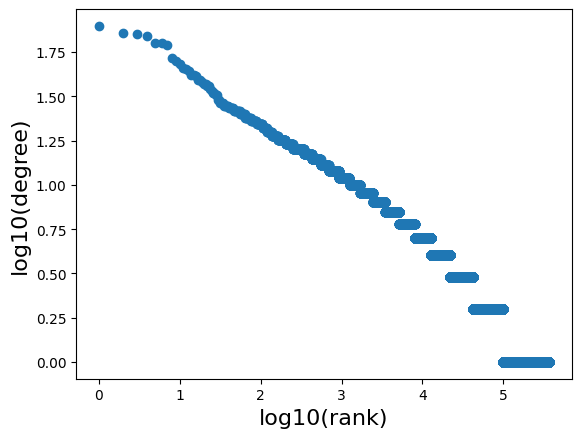

In [8]:
plt.scatter(np.log10(range(H.num_nodes)) ,np.log10(sorted(list(H.degree().values()))[::-1]))
plt.xlabel("log10(rank)", fontsize=16)
plt.ylabel("log10(degree)", fontsize=16)

In [9]:
'''
is_connected = xgi.is_connected(H)
if is_connected:
    print(f"H is connected")
else:
    print(f"H is not connected")

print(f"The sizes of the connected components are:")
print([len(component) for component in xgi.connected_components(H)])

(
    H.nodes.multi(["degree", "clustering_coefficient", "average_neighbor_degree"])
    .aspandas()
    .groupby("degree")
    .agg("mean")
    .plot(marker="o")
)

I = xgi.incidence_matrix(H, sparse=False)
plt.spy(I, aspect="auto")
plt.xlabel("Hyperedges", fontsize=16)
plt.ylabel("Nodes", fontsize=16)
plt.show()

A = xgi.adjacency_matrix(H, sparse=False)
plt.spy(A, aspect="auto")
plt.xlabel("Hyperedges", fontsize=16)
plt.ylabel("Nodes", fontsize=16)
plt.show()

'''

'\nis_connected = xgi.is_connected(H)\nif is_connected:\n    print(f"H is connected")\nelse:\n    print(f"H is not connected")\n\nprint(f"The sizes of the connected components are:")\nprint([len(component) for component in xgi.connected_components(H)])\n\n(\n    H.nodes.multi(["degree", "clustering_coefficient", "average_neighbor_degree"])\n    .aspandas()\n    .groupby("degree")\n    .agg("mean")\n    .plot(marker="o")\n)\n\nI = xgi.incidence_matrix(H, sparse=False)\nplt.spy(I, aspect="auto")\nplt.xlabel("Hyperedges", fontsize=16)\nplt.ylabel("Nodes", fontsize=16)\nplt.show()\n\nA = xgi.adjacency_matrix(H, sparse=False)\nplt.spy(A, aspect="auto")\nplt.xlabel("Hyperedges", fontsize=16)\nplt.ylabel("Nodes", fontsize=16)\nplt.show()\n\n'